In [2]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [3]:
m = pd.read_csv('dataset/ceb-matrix.csv', index_col='filename').to_numpy()
pg_total = m[:, 0].sum()
optimal_total = np.min(m, axis=1).sum()
print('pg_total:', pg_total)
print('optimal_total:', optimal_total)

pg_p90 = np.percentile(m[:, 0], 90)
optimal_p90 = np.percentile(np.min(m, axis=1), 90)
print('pg_p90:', pg_p90)
print('optimal_p90:', optimal_p90)

pg_total: 10587.665450334549
optimal_total: 3688.4883341789246
pg_p90: 4.558033323287964
optimal_p90: 2.603392314910889


In [4]:
m.sum() / 3600 / 24

12.429885430642301

In [5]:
def get_data(filename):
    total_latency = []
    p50 = []
    p90 = []
    p95 = []
    p99 = []
    execution_time = []
    training_time = []
    inference_time = []
    mse = []

    with open(filename) as f:
        results = json.load(f)
        for result in results:
            total_latency.append(result["total_latency"] / 3600)
            p50.append(result["p50"])
            p90.append(result["p90"])
            p95.append(result["p95"])
            p99.append(result["p99"])
            execution_time.append(result["exec_time"] / 3600 - pg_total / 3600)
            training_time.append(result["training_time"])
            inference_time.append(result["inference_time"])
            if "mse" in result:
                mse.append(result["mse"])
    
    training_time_cdf = np.cumsum(training_time)
    inference_time_cdf = np.cumsum(inference_time)
    pg_total_hour = pg_total / 3600
    df = pd.DataFrame({
        "total_latency": total_latency,
        "improvement": (pg_total_hour - total_latency) / pg_total_hour,
        "latency_median": p50,
        "latency_p90": p90,
        "latency_p95": p95,
        "latency_p99": p99,
        "execution_time": execution_time,
        # "execution_time": execution_time + (training_time_cdf + inference_time_cdf) / 3600,
        "training_time": training_time,
        "inference_time": inference_time,
    })
    df['overhead_time'] = df['training_time'] + df['inference_time']
    df['overhead_time_cdf'] = df['overhead_time'].cumsum()
    
    if len(mse) > 0:
        df["mse"] = mse
    
    return df

In [6]:
def combine_plot(p_mc_lists, mc_lists):

    start = -np.inf
    end = np.inf
    for i in range(len(p_mc_lists)):
        p_min = np.min(p_mc_lists[i])
        p_max = np.max(p_mc_lists[i])
        start = max(start, p_min)
        end = min(end, p_max)
    
    
    x_combined = np.linspace(start, end, 5000)
    y_combined = np.zeros_like(x_combined)
    fi_list = []
    for i in range(len(p_mc_lists)):
        fi = interp1d(p_mc_lists[i], mc_lists[i], kind='linear')
        y_combined += fi(x_combined)
        fi_list.append(fi(x_combined))

    y_combined = y_combined / len(p_mc_lists)
    std = np.std(fi_list, axis=0)
    p25 = np.percentile(fi_list, 25, axis=0)
    p75 = np.percentile(fi_list, 75, axis=0)
    
    return x_combined, y_combined, std, p25, p75

def get_y(x, y, std, p25,p75, x_target):
    x_ = x[x > x_target * 0.99]
    x_ = x_[x_ < x_target * 1.01]
    x_ = x_[len(x_)//2]
    x_index = x.tolist().index(x_)
    return x_, y[x_index], std[x_index], p25[x_index], p75[x_index]

def get_multiple(path, x_name, y_name, n=20):

    x_list, y_list = [], []
    for i in range(1,n+1):
        df = get_data(path.format(i))
        x_list.append(df[x_name])
        y_list.append(df[y_name])
    
    x, y, std, p25, p75  = combine_plot(x_list, y_list)
    
    checkpoint_list = [0.375, 0.75, 1.5, 3, 6, 12]
    

    l = []
    try:
        for checkpoint in checkpoint_list:
            l.append(get_y(x, y, std, p25, p75, checkpoint))
    except:
        pass
        
    return x, y, std, l

In [14]:
linewidth=3
markersize=10
gridwidth=1.5
bwith=2
ticks_fontsize = 16.5
label_fontsize = 20
fontweight='normal'
markeredgecolor = 'k'
color_scheme = [
    "#4995c6",  # 蓝色
    "#d47628",  # 黄色
    "#8fb943",  # 绿色
    "#d15c6b",  # 红色
    "#8481ba",  # 紫色
    "#413123",  # 棕色
    "#f7a128",  # 橙色,
    "#a5a5a5",  # 灰色,
    "#011F5B",  # 深蓝色
]

line_styles = ['-', '--', '-.', ':']

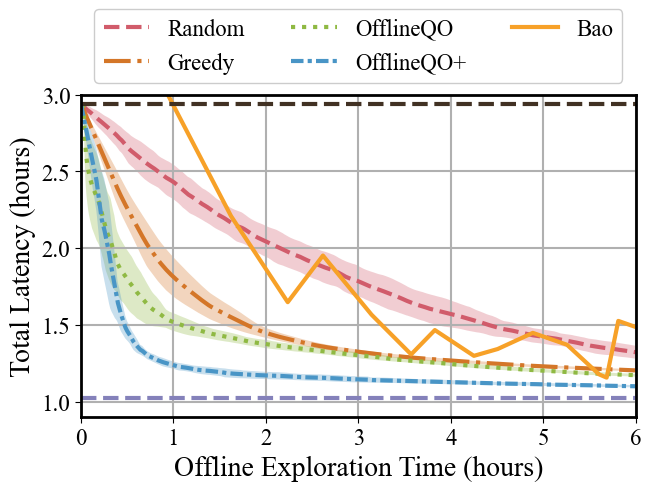

In [16]:

fig, ax = plt.subplots(1,1, constrained_layout=True)

# set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# ax = axs[0]
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', length=4, labelsize=ticks_fontsize)
ax.tick_params(axis='y', length=4, labelsize=ticks_fontsize)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

x, y, std, random = get_multiple("experiment/ceb/random/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[3], label='Random', linestyle=line_styles[1],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[3], linewidth=0)

x, y, std, greedy = get_multiple("experiment/ceb/greedy/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[1], label='Greedy', linestyle=line_styles[2],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[1], linewidth=0)

x, y, std, limeqo = get_multiple("experiment/ceb/limeqo/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[2], label='OfflineQO', linestyle=line_styles[3],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[2], linewidth=0)

x, y, std, limeqo_embd = get_multiple("experiment/ceb/limeqo+/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = color_scheme[0], label='OfflineQO+', linestyle=(0, (3, 1, 1, 1)),  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[0], linewidth=0)

# x, y, std, tcnn = get_multiple("experiment/ceb/tcnn/{}.json", "execution_time", "total_latency", n=2)
# ax.plot(x, y, color = color_scheme[8], label='TCNN', linestyle=line_styles[3],  linewidth=linewidth)
# ax.fill_between(x, y - std, 
#                 y + std, alpha=0.3, color = color_scheme[8], linewidth=0)

df = get_data("experiment/ceb/bao/bao_1.json")
ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[6], label='Bao', linestyle=line_styles[0],  linewidth=linewidth)

# df = get_data("experiment/ceb/oracle.json")
# ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[4], label='Oracle', linestyle=line_styles[4],  linewidth=linewidth)

ax.axhline(pg_total/3600, color = color_scheme[5], linestyle=line_styles[1], linewidth=linewidth) # PG
ax.axhline(optimal_total/3600, color = color_scheme[4], linestyle=line_styles[1], linewidth=linewidth) # Optimal

ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.3))
ax.grid('--')
ax.set_xlim(-0, 6)
ax.set_ylim(0.9, 3)
ax.set_xticks([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])
ax.set_yticks([1.0, 1.5, 2.0, 2.5,3.0], [1.0, 1.5, 2.0, 2.5,3.0])
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize)

# ax = axs[1]

# ax.spines['bottom'].set_linewidth(bwith)
# ax.spines['left'].set_linewidth(bwith)
# ax.spines['top'].set_linewidth(bwith)
# ax.spines['right'].set_linewidth(bwith)
# ax.tick_params(axis='x', length=4, labelsize=ticks_fontsize)
# ax.tick_params(axis='y', length=4, labelsize=ticks_fontsize)
# # axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
# ax.grid(linewidth=gridwidth)

# x, y, std, _ = get_multiple("experiment/ceb/limeqo/{}.json", "execution_time", "overhead_time_cdf", n=20)
# ax.plot(x, y, color = color_scheme[2], linestyle=line_styles[3],  linewidth=linewidth)
# ax.fill_between(x, y - std, 
#                 y + std, alpha=0.3, color = color_scheme[2], linewidth=0)

# x, y, std, _ = get_multiple("experiment/ceb/limeqo+/{}.json", "execution_time", "overhead_time_cdf", n=1)
# ax.plot(x, y, color = color_scheme[0], linestyle=(0, (3, 1, 1, 1)),  linewidth=linewidth)
# ax.fill_between(x, y - std, 
#                 y + std, alpha=0.3, color = color_scheme[0], linewidth=0)

# x, y, std, _ = get_multiple("experiment/ceb/limeqo+/rank5/{}.json", "execution_time", "overhead_time_cdf", n=5)
# ax.plot(x, y, color = color_scheme[4], label='OfflineQO+(GPU)', linestyle=(0, (3, 2, 1, 1)),  linewidth=linewidth)
# ax.fill_between(x, y - std, 
#                 y + std, alpha=0.3, color = color_scheme[4], linewidth=0)

# x, y, std, _ = get_multiple("experiment/ceb/tcnn/{}.json", "execution_time", "overhead_time_cdf", n=2)
# ax.plot(x, y, color = color_scheme[8], label='TCNN(CPU)', linestyle=line_styles[1],  linewidth=linewidth)
# ax.fill_between(x, y - std, 
#                 y + std, alpha=0.3, color = color_scheme[8], linewidth=0)

# df = get_data("experiment/ceb/bao/bao_1.json")
# ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[6], label='Bao', linestyle=line_styles[0],  linewidth=linewidth)

# df = get_data("experiment/ceb/oracle.json")
# ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[4], label='Oracle', linestyle=line_styles[4],  linewidth=linewidth)

# fig.legend(framealpha=1,loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.27), fontsize=25)
# ax.grid('--')
# ax.set_yscale('log')
# ax.set_xlim(-0, 6)
# ax.set_ylim(0, 1000)
# ax.set_xticks([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])
# ax.set_yticks([0.1, 1, 10, 100, 1000, 5000], [0.1, 1, 10, 100, 1000, 5000])
# ax.set_ylabel('Overhead Time (s) \n (Log Scale)', fontsize=label_fontsize)
# ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize)


plt.savefig('fig/ceb.pdf', bbox_inches='tight')

/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_75700/2988683631.py:47: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1000)


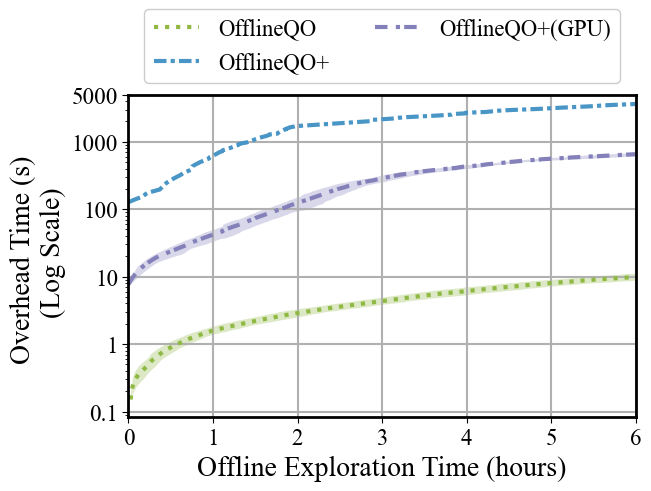

In [18]:

fig, ax = plt.subplots(1,1, constrained_layout=True)

# set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# ax = axs[0]
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', length=4, labelsize=ticks_fontsize)
ax.tick_params(axis='y', length=4, labelsize=ticks_fontsize)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)


x, y, std, _ = get_multiple("experiment/ceb/limeqo/{}.json", "execution_time", "overhead_time_cdf", n=20)
ax.plot(x, y, color = color_scheme[2], label='OfflineQO',linestyle=line_styles[3],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[2], linewidth=0)

x, y, std, _ = get_multiple("experiment/ceb/limeqo+/{}.json", "execution_time", "overhead_time_cdf", n=1)
ax.plot(x, y, color = color_scheme[0], label='OfflineQO+', linestyle=(0, (3, 1, 1, 1)),  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[0], linewidth=0)

x, y, std, _ = get_multiple("experiment/ceb/limeqo+/rank5/{}.json", "execution_time", "overhead_time_cdf", n=5)
ax.plot(x, y, color = color_scheme[4], label='OfflineQO+(GPU)', linestyle=(0, (3, 2, 1, 1)),  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[4], linewidth=0)

# x, y, std, _ = get_multiple("experiment/ceb/tcnn/{}.json", "execution_time", "overhead_time_cdf", n=2)
# ax.plot(x, y, color = color_scheme[8], label='TCNN(CPU)', linestyle=line_styles[1],  linewidth=linewidth)
# ax.fill_between(x, y - std, 
#                 y + std, alpha=0.3, color = color_scheme[8], linewidth=0)

# df = get_data("experiment/ceb/bao/bao_1.json")
# ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[6], label='Bao', linestyle=line_styles[0],  linewidth=linewidth)

# df = get_data("experiment/ceb/oracle.json")
# ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[4], label='Oracle', linestyle=line_styles[4],  linewidth=linewidth)

ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.3))
ax.grid('--')
ax.set_yscale('log')
ax.set_xlim(-0, 6)
ax.set_ylim(0, 1000)
ax.set_xticks([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])
ax.set_yticks([0.1, 1, 10, 100, 1000, 5000], [0.1, 1, 10, 100, 1000, 5000])
ax.set_ylabel('Overhead Time (s) \n (Log Scale)', fontsize=label_fontsize)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize)


plt.savefig('fig/overhead.pdf', bbox_inches='tight')

/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_71527/3454906440.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0]+labels)


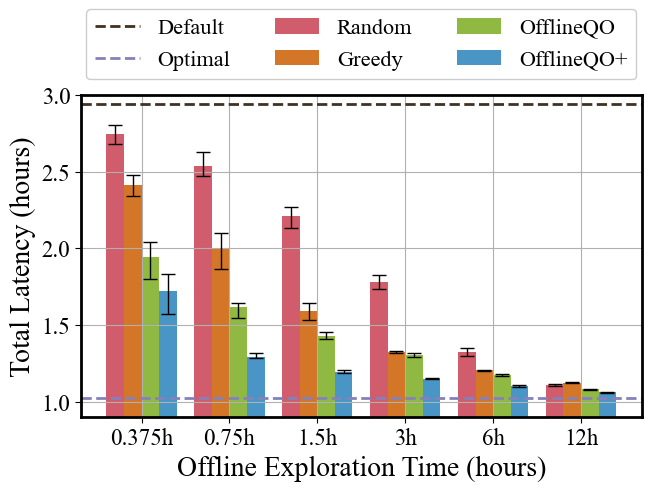

In [40]:
labels = ['0.375h', '0.75h', '1.5h', '3h', '6h', '12h']
lines = []
line = ['Random', 'Greedy', 'LimeQO', 'LimeQO+']
lines.append(','.join(line))
for i in range(len(labels)):
    line = [labels[i], random[i][1], greedy[i][1], limeqo[i][1], limeqo_embd[i][1]]
    line = ','.join([str(x) for x in line])
    lines.append(line)

with open('result/ceb.csv', "w") as f:
    f.write('\n'.join(lines))
    
ticks_fontsize = 16.5
label_fontsize = 20
    
fig, ax = plt.subplots(1,1,constrained_layout=True)
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)

x = np.arange(len(labels))
width = 0.2
# draw bar with error bar

ax.bar(x - 1.5 * width, [random[i][1] for i in range(6)], width, label='Random', color=color_scheme[3], yerr=[[random[i][1] - random[i][3] for i in range(6)],[random[i][4] - random[i][1] for i in range(6)]], error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1})
ax.bar(x - 0.5 * width, [greedy[i][1] for i in range(6)], width, label='Greedy', color=color_scheme[1], yerr=[[greedy[i][1] - greedy[i][3] for i in range(6)],[greedy[i][4] - greedy[i][1] for i in range(6)]], error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1})
ax.bar(x + 0.5 * width, [limeqo[i][1] for i in range(6)], width, label='OfflineQO', color=color_scheme[2], yerr=[[limeqo[i][1] - limeqo[i][3] for i in range(6)],[limeqo[i][4] - limeqo[i][1] for i in range(6)]], error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1})
ax.bar(x + 1.5 * width, [limeqo_embd[i][1] for i in range(6)], width, label='OfflineQO+', color=color_scheme[0], yerr=[[max(0,limeqo_embd[i][1] - limeqo_embd[i][3]) for i in range(6)],[max(0,limeqo_embd[i][4] - limeqo_embd[i][1]) for i in range(6)]], error_kw={'ecolor': 'black', 'capsize': 5, 'elinewidth': 1})

ax.axhline(pg_total/3600, color = color_scheme[5], label='Default', linestyle=line_styles[1], linewidth=2) # PG
ax.axhline(optimal_total/3600, color = color_scheme[4], label='Optimal',linestyle=line_styles[1], linewidth=2) # Optimal

ax.set_xticklabels([0]+labels)
ax.set_ylim(0.9, 3)
ax.grid('--')
ax.legend(framealpha=1,fontsize=16, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.3))
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize, fontweight=fontweight)

fig.savefig('fig/ceb_bar.pdf', bbox_inches='tight')